<a href="https://colab.research.google.com/github/Abhishek-TyRnT/TyRnT/blob/master/Deepdream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

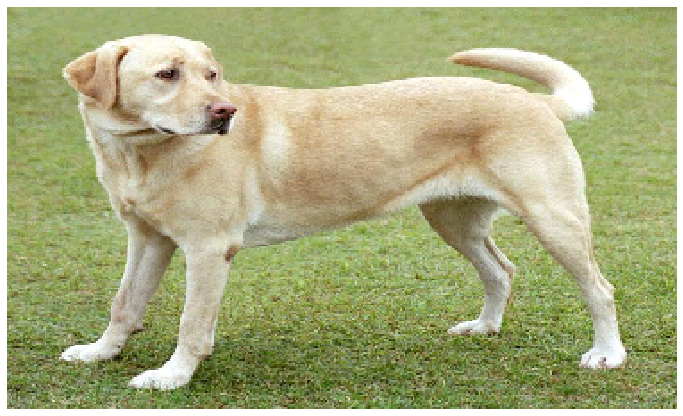

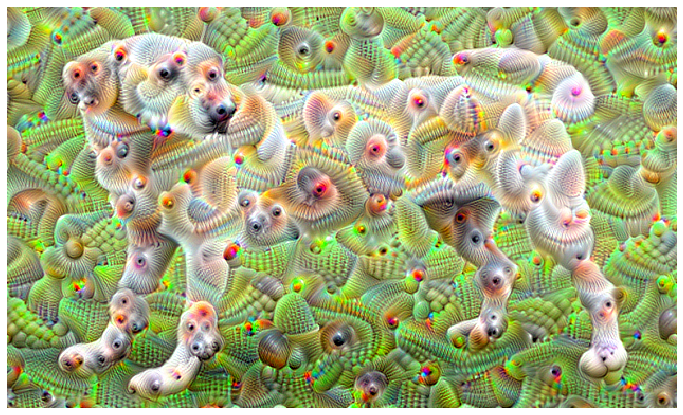

In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib as mpl
from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
url='https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

def random_roll(img,maxroll):
  shift=tf.random.uniform(shape=[2],minval=-maxroll,maxval=maxroll,dtype=tf.int32)
  shift_down,shift_right=shift[0],shift[1]
  img_rolled=tf.roll(tf.roll(img,shift_right,axis=1),shift_down,axis=0)
  return shift_down,shift_right,img_rolled
def download(url,target_size=None):
  name=url.split('/')[-1]
  image_path=tf.keras.utils.get_file(name,origin=url)
  img=tf.keras.preprocessing.image.load_img(image_path,target_size=target_size)
  return img

def deprocess(img):
  img=255*(img+1.0)/2.0
  return tf.cast(img,tf.uint8)

def show(img):
  plt.figure(figsize=(12,12))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)
  plt.show()

img=download(url,target_size=[225,375])

base_model=tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
names=['mixed3','mixed5']
layers=[base_model.get_layer(name).output for name in names]
dream_model=tf.keras.Model(inputs=base_model.input,outputs=layers)

def calc_loss(img,model):

  img_batch=tf.expand_dims(img,axis=0)
  layer_activations=model(img_batch)

  losses=[]
  for act in layer_activations:
    loss=tf.math.reduce_mean(act)
    losses.append(loss)

  return tf.reduce_sum(losses)

@tf.function

def get_tiled_gradients(model,img,tile_size=512):
  shift_down, shift_right, img_rolled = random_roll(img, tile_size)

  # Initialize the image gradients to zero.
  gradients = tf.zeros_like(img_rolled)

  for x in tf.range(0, img_rolled.shape[0], tile_size):
    for y in tf.range(0, img_rolled.shape[1], tile_size):
      # Calculate the gradients for this tile.
      with tf.GradientTape() as tape:
        # This needs gradients relative to `img_rolled`.
        # `GradientTape` only watches `tf.Variable`s by default.
        tape.watch(img_rolled)

        # Extract a tile out of the image.
        img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
        loss = calc_loss(img_tile, model)

      # Update the image gradients for this tile.
      gradients = gradients + tape.gradient(loss, img_rolled)

  # Undo the random shift applied to the image and its gradients.
  gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

  # Normalize the gradients.
  gradients /= tf.math.reduce_std(gradients) + 1e-8 

  return gradients 


def run_deep_dream_with_octaves(model,img,steps_per_octave=100,step_size=0.01,
                          num_octaves=3,octave_scale=1.3):
  img=tf.keras.preprocessing.image.img_to_array(img)
  img=tf.keras.applications.inception_v3.preprocess_input(img)

  for octave in range(num_octaves):
    if octave>0:
     new_size=tf.cast(tf.convert_to_tensor(img.shape[:2]),tf.float32)*octave_scale
     img=tf.image.resize(img,tf.cast(new_size,tf.int32))
    
    for step in range(steps_per_octave):
      gradients=get_tiled_gradients(model,img)
      img=img+gradients*step_size
      img=tf.clip_by_value(img,-1,1)


    if step%10==0:
      clear_output(wait=True)
      show(deprocess(img))
      print("Octave{},loss{}".format(step,loss))

  result=deprocess(img)
  clear_output(wait=True)
  show(result)

  return result
"""OCTAVE_SCALE=1.3
for n in range(3):
  new_shape=tf.cast(base_shape*(OCTAVE_SCALE**n),tf.int32)
  img=tf.image.resize(img,new_shape).numpy()
  img=run_deep_dream_simple(model=dream_model,img=img,steps=200,step_size=0.001)

clear_output(wait=True)
show(img)"""

dream_img=run_deep_dream_with_octaves(model=dream_model,img=original_img,step_size=0.01)

clear_output()
show(original_img)
show(dream_img)


